In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 679 kB 10.4 MB/s 


# Import package


In [3]:
import numpy as np # linear algebra
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, LSTM, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional,dot,SpatialDropout1D, Activation,Conv1D,Dropout,MaxPooling1D,GlobalAveragePooling1D,Flatten,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Accuracy, Recall, Precision, AUC
from sklearn.metrics import confusion_matrix,classification_report
# from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns


import warnings
#pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.5.0


# Read Data

In [4]:
train_df = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/DataText/PPV2train_news.csv")
train_df.text=train_df.text.astype(str)

val_df = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/DataText/PPV2val_news.csv")
val_df.text=val_df.text.astype(str)

test_df = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/DataText/PPV2test_news.csv")
test_df.text=test_df.text.astype(str)

train_df.shape , test_df.shape ,val_df.shape

((5128, 2), (1603, 2), (1282, 2))

In [5]:
train_df.label.value_counts().sort_values()

0    1304
1    3824
Name: label, dtype: int64

In [6]:
val_df.label.value_counts().sort_values()

0    304
1    978
Name: label, dtype: int64

In [7]:
test_df.label.value_counts().sort_values()

0     405
1    1198
Name: label, dtype: int64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5128 entries, 0 to 5127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5128 non-null   object
 1   label   5128 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.2+ KB


In [9]:
len(train_df.text),len(train_df.label)

(5128, 5128)

In [10]:
longest_text= 0
for sent in train_df['text']:
  #print(sent)
  if len(sent.split()) > longest_text:
      longest_text = len(sent.split())

print(longest_text)


5809


# Siplt Label

In [11]:
x_train=train_df['text']
y_train=train_df['label']

x_val=val_df['text']
y_val=val_df['label']

x_test=test_df['text']
y_test=test_df['label']

In [12]:
x_train.shape, x_val.shape 

((5128,), (1282,))

# Tokenizer, sequences & padding

In [13]:
MAX_NB_WORDS = 20000
MAX_TEXT_LEN = 2000

In [14]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=MAX_NB_WORDS) 
x_tokenizer.fit_on_texts(x_train)

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_train =   pad_sequences(x_train_seq,  maxlen=MAX_TEXT_LEN, padding='post')
x_val   =   pad_sequences(x_val_seq,    maxlen=MAX_TEXT_LEN, padding='post')

#size of vocabulary ( +1 for padding token)
VOC_SIZE =  len(x_tokenizer.word_index) +1 
print("Size of vocabulary in X = {}".format(VOC_SIZE))

Size of vocabulary in X = 100779


In [15]:
#prepare test data set
x_test_seq   =   x_tokenizer.texts_to_sequences(x_test)
x_test   =   pad_sequences(x_test_seq,    maxlen=MAX_TEXT_LEN, padding='post')

In [16]:
x_train[:1],y_train[:1]

(array([[1347, 3298, 2866, ...,    0,    0,    0]], dtype=int32), 0    1
 Name: label, dtype: int64)

# Plot Function

In [17]:
def plot_model_learning(history, title):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    df = pd.DataFrame(history.history)
    df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
    df[['loss', 'val_loss']].plot(ax=ax[1])
    ax[0].set_title('Model Accuracy', fontsize=12)
    ax[1].set_title('Model Loss', fontsize=12)
    fig.suptitle(f'{title}: Model Metrics', fontsize=18)

In [18]:
# Showing Confusion Matrix
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# Train Model

## Constant

In [19]:
METRICS = [
    tf.keras.metrics.AUC(name='roc-auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(num_classes=1,average='macro',name='f1_score',threshold=0.5 )
      ]

In [20]:
def callbacks(filepath):
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  #ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
  #rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)
  return es#,ckpt,rlp

In [21]:
# optimizers
adam = tf.keras.optimizers.Adam(lr = 0.001)

In [22]:
Embedding_DIM=300
MAX_EPOCHS=100
BATCH_SIZE=64
val_dict = {"NAME":[],"METRICS":[],"CONFUSION_MATRIX":[]};
test_dict = {"NAME":[],"METRICS":[],"CONFUSION_MATRIX":[]};

## Bidirectional Lstm

In [23]:
def bidirectional_lstm():
    model = Sequential()
    model.add(Input(shape=(MAX_TEXT_LEN,), dtype="int32"))
    model.add(Embedding(VOC_SIZE, Embedding_DIM, trainable=True))
    model.add(Bidirectional(LSTM(32, return_sequences = True, dropout=0.3)))
    model.add(Bidirectional(LSTM(64, return_sequences = True , dropout=0.3)))
    model.add(Bidirectional(LSTM(128, return_sequences = True , dropout=0.3)))
    model.add(Bidirectional(LSTM(64, return_sequences = False, dropout=0.3 )))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=METRICS)
    
    return model

model = bidirectional_lstm()
model.summary()

history = model.fit(x_train,y_train,
                    epochs=MAX_EPOCHS,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks('bidirectional_lstm.png')],
                    batch_size=BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 300)         30233700  
_________________________________________________________________
bidirectional (Bidirectional (None, 2000, 64)          85248     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2000, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2000, 256)         263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 30,812,645
Trainable params: 30,812,645
Non-trainable params: 0
____________________________________________

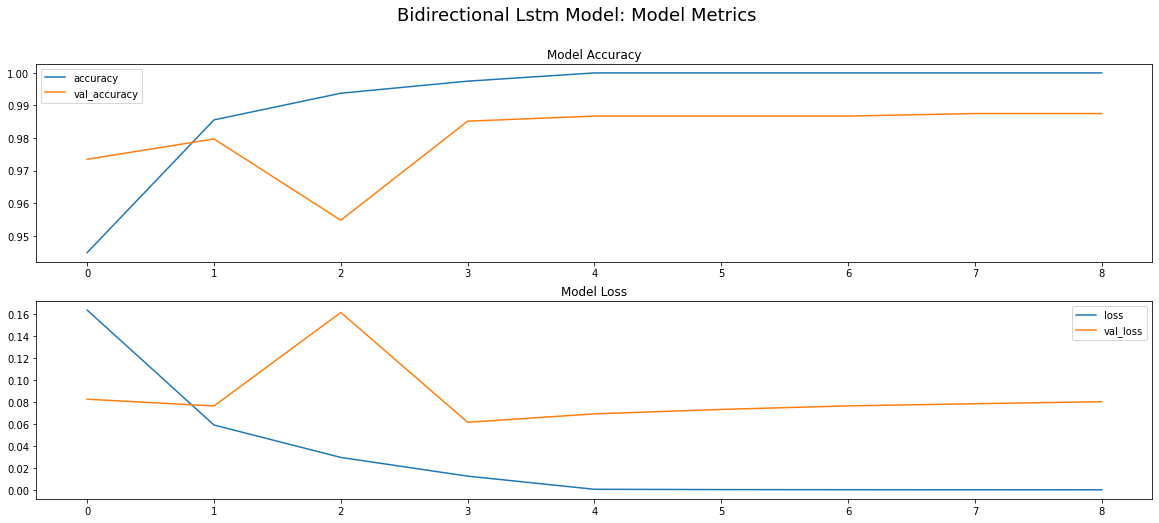

In [24]:
#Plot Model
plot_model_learning(history,'Bidirectional Lstm Model')

### Model Evaluation

41/41 [==============================] - 28s 675ms/step - loss: 0.0801 - roc-auc: 0.9878 - accuracy: 0.9875 - precision: 0.9888 - recall: 0.9949 - f1_score: 0.9918
Accuracy: 98.75%

Classification report
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       304
           1       0.99      0.99      0.99       978

    accuracy                           0.99      1282
   macro avg       0.99      0.98      0.98      1282
weighted avg       0.99      0.99      0.99      1282

Confusion matrix : 293 11 5 973
{'NAME': ['bid_lstm'], 'METRICS': [[0.08010690659284592, 0.9877720475196838, 0.9875195026397705, 0.9888211488723755, 0.9948875308036804, 0.9918451309204102]], 'CONFUSION_MATRIX': [[293, 11, 5, 973]]}


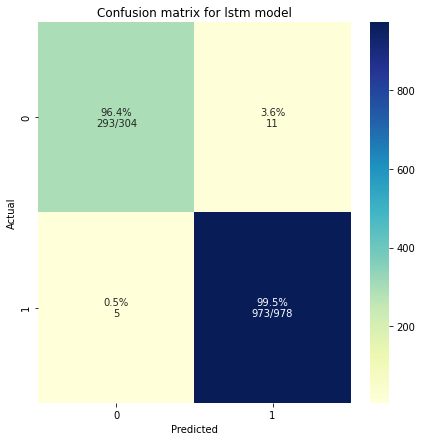

In [25]:
# Evaluate Model
scores = model.evaluate(x_val, y_val)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_val)

print("\nClassification report\n",classification_report(y_val, y_pred))

#Confusion matrix
tn ,fb ,fn , tp= confusion_matrix(y_val, y_pred).ravel()
print("Confusion matrix :",tn ,fb ,fn , tp)

#plot Confusion matrix
plot_cm(y_val, y_pred, 'Confusion matrix for lstm model', figsize=(7,7))

val_dict["NAME"].append("bid_lstm")
val_dict["METRICS"].append(scores)
val_dict["CONFUSION_MATRIX"].append([tn ,fb ,fn , tp])
print(val_dict)

### Evaluate Model on Test DataSet`

51/51 [==============================] - 35s 674ms/step - loss: 0.1008 - roc-auc: 0.9842 - accuracy: 0.9807 - precision: 0.9802 - recall: 0.9942 - f1_score: 0.9872
Accuracy: 98.07%

Classification report
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       405
           1       0.98      0.99      0.99      1198

    accuracy                           0.98      1603
   macro avg       0.98      0.97      0.97      1603
weighted avg       0.98      0.98      0.98      1603

Confusion matrix: 381 24 7 1191


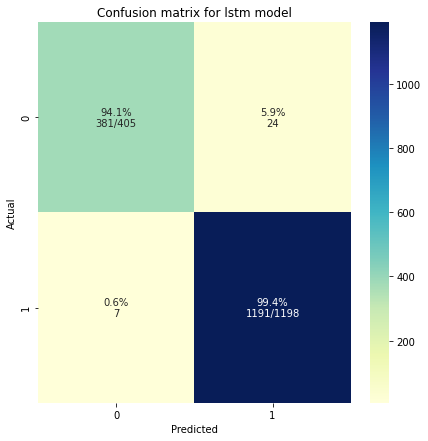

In [26]:
# Evaluate Model
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_test)
print("\nClassification report\n",classification_report(y_test, y_pred))

#Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion matrix:", tn, fp, fn, tp)

#plot Confusion matrix
plot_cm(y_test, y_pred, 'Confusion matrix for lstm model', figsize=(7,7))

test_dict["NAME"].append("bid_lstm")
test_dict["METRICS"].append(scores)
test_dict["CONFUSION_MATRIX"].append([tn, fp, fn, tp])

### Sample

In [27]:
text_example = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/Data/text_example.csv")
text_example.shape
count=0

for text in text_example.text:
  text_seq =  x_tokenizer.texts_to_sequences([text])
  text_pad   =   pad_sequences(text_seq,maxlen=MAX_TEXT_LEN, padding='post')
  y_label  =   model.predict_classes(text_pad)
  # y_pred= np.where(y_label > .5, 1, 0)
  if y_label==1 :
    count=count+1
    
print("Real : "+str(count))

Real : 16


## Deep Bidirectional GRU

In [28]:
def deep_bidirectional_gru():
    model = Sequential()
    model.add(Input(shape=(MAX_TEXT_LEN,), dtype="int32"))
    model.add(Embedding(VOC_SIZE, Embedding_DIM, trainable=True))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(GRU(32, return_sequences = True, dropout=0.3)))
    model.add(Bidirectional(GRU(64, return_sequences = True , dropout=0.3)))
    model.add(Bidirectional(GRU(128, return_sequences = True , dropout=0.3)))
    model.add(Bidirectional(GRU(64, return_sequences = False, dropout=0.3 )))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=METRICS)
    
    return model

model = deep_bidirectional_gru()
model.summary()

history = model.fit(x_train,y_train,
                    epochs=MAX_EPOCHS,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks('deep_bidirectional_gru.png')],
                    batch_size=BATCH_SIZE)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 300)         30233700  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 2000, 300)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 2000, 64)          64128     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 2000, 128)         49920     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 2000, 256)         198144    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               123648    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

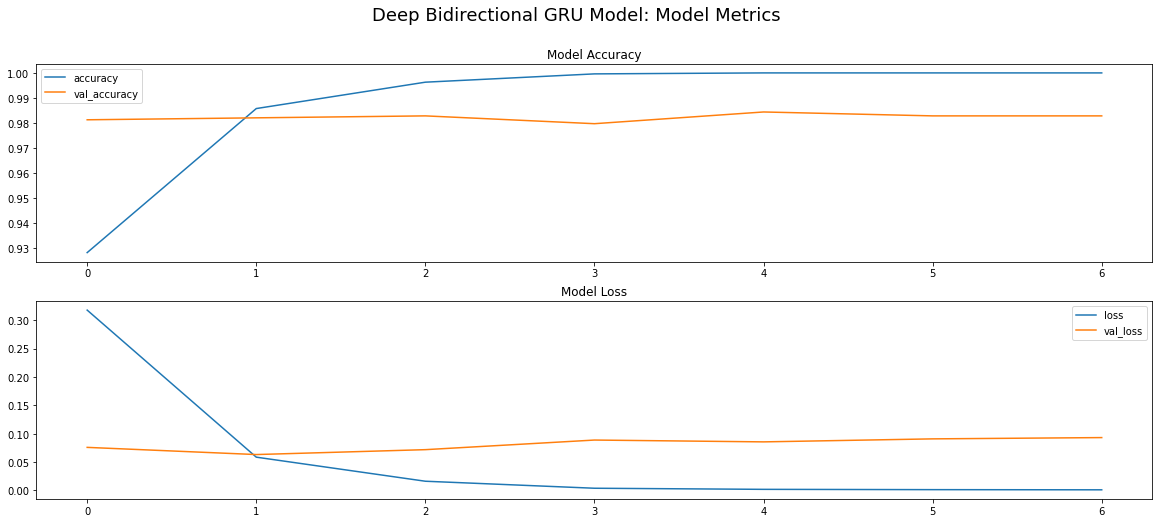

In [29]:
plot_model_learning(history, 'Deep Bidirectional GRU Model')

### Model Evaluation

41/41 [==============================] - 29s 707ms/step - loss: 0.0932 - roc-auc: 0.9808 - accuracy: 0.9828 - precision: 0.9838 - recall: 0.9939 - f1_score: 0.9888
Accuracy: 98.28%

Classification report
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       304
           1       0.98      0.99      0.99       978

    accuracy                           0.98      1282
   macro avg       0.98      0.97      0.98      1282
weighted avg       0.98      0.98      0.98      1282

Confusion matrix : 288 16 6 972
{'NAME': ['bid_lstm', 'deep_bid_gru'], 'METRICS': [[0.08010690659284592, 0.9877720475196838, 0.9875195026397705, 0.9888211488723755, 0.9948875308036804, 0.9918451309204102], [0.09318013489246368, 0.9808366298675537, 0.9828392863273621, 0.9838056564331055, 0.9938650131225586, 0.9888097643852234]], 'CONFUSION_MATRIX': [[293, 11, 5, 973], [288, 16, 6, 972]]}


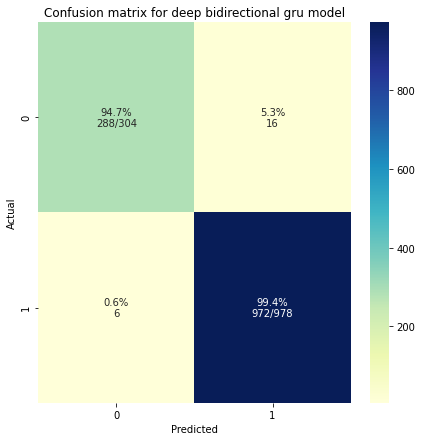

In [30]:
# Evaluate Model
scores = model.evaluate(x_val, y_val)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_val)
print("\nClassification report\n",classification_report(y_val, y_pred))

#Confusion matrix
tn ,fb ,fn , tp= confusion_matrix(y_val, y_pred).ravel()
print("Confusion matrix :",tn ,fb ,fn , tp)

#plot Confusion matrix
plot_cm(y_val, y_pred, 'Confusion matrix for deep bidirectional gru model', figsize=(7,7))

val_dict["NAME"].append("deep_bid_gru")
val_dict["METRICS"].append(scores)
val_dict["CONFUSION_MATRIX"].append([tn ,fb ,fn , tp])
print(val_dict)

### Evaluate Model on Test DataSet




51/51 [==============================] - 36s 694ms/step - loss: 0.0970 - roc-auc: 0.9827 - accuracy: 0.9800 - precision: 0.9842 - recall: 0.9891 - f1_score: 0.9867
Accuracy: 98.00%

Classification report
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       405
           1       0.98      0.99      0.99      1198

    accuracy                           0.98      1603
   macro avg       0.98      0.97      0.97      1603
weighted avg       0.98      0.98      0.98      1603

Confusion matrix: 386 19 13 1185


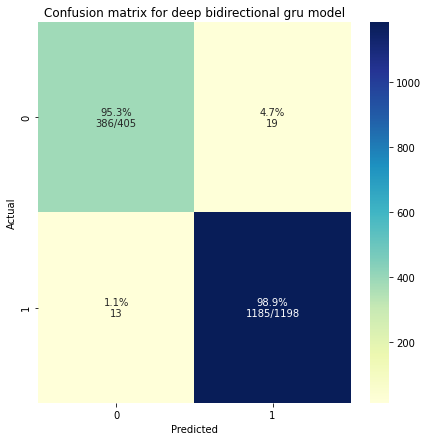

In [31]:
# Evaluate Model
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_test)
print("\nClassification report\n",classification_report(y_test, y_pred))

#Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion matrix:", tn, fp, fn, tp)

#plot Confusion matrix
plot_cm(y_test, y_pred, 'Confusion matrix for deep bidirectional gru model', figsize=(7,7))

test_dict["NAME"].append("deep_bid_gru")
test_dict["METRICS"].append(scores)
test_dict["CONFUSION_MATRIX"].append([tn, fp, fn, tp])

### Sample

In [32]:
text_example = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/Data/text_example.csv")
text_example.shape
count=0

for text in text_example.text:
  text_seq =  x_tokenizer.texts_to_sequences([text])
  text_pad   =   pad_sequences(text_seq,maxlen=MAX_TEXT_LEN, padding='post')
  y_label  =   model.predict_classes(text_pad)
  # y_pred= np.where(y_label > .5, 1, 0)
  if y_label==1 :
    count=count+1
    
print("Real : "+str(count))

Real : 16


## fastText

In [33]:
from tqdm.auto import tqdm
from keras.initializers import Constant

In [34]:
embedding_dim=300
seq_length = longest_text

In [35]:
from gensim.models.keyedvectors import KeyedVectors

def prepare_embedding_index(embedding_name):
    embeddings_index = {}
    if embedding_name == 'Glove':
        f = open('/content/drive/MyDrive/Arabic_FakeNews/Model/Pretrain_Model/GloVe/vocab.txt')
        #embedding_dim = 200
    if embedding_name == 'fastText':
        f = open('/content/drive/MyDrive/Arabic_FakeNews/Model/Pretrain_Model/fastText/cc.ar.300.vec')
        #embedding_dim = 300
    #elif embedding_name == 'AraVec':
        #f = gensim.models.Word2Vec.load('/content/full_grams_cbow_300_twitter.mdl')
        #embedding_dim = 300
        
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    
    return embeddings_index, embedding_dim


def prepare_embedding_matrix(embeddings_index, embedding_dim, VOC_SIZE, tokenizer):
    count_known = 0
    count_unknown = 0
        
    embedding_matrix = np.zeros((VOC_SIZE, embedding_dim))

    for word, i in tqdm(tokenizer.word_index.items()):
        if i >= VOC_SIZE:
            continue
        embedding_vector = None
        try:
            embedding_vector = embeddings_index[word]
        except:
            pass
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            count_known += 1
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)
            count_unknown += 1

    print(f'{count_known} known vectors\n{count_unknown} random vectors') 
    return embedding_matrix


94940 known vectors
5838 random vectors
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 300)         30233700  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 2000, 64)          85248     
_________________________________________________________________
dropout (Dropout)            (None, 2000, 64)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 2000, 128)         66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 128)         0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 2000, 256)         263168    
_________________________________________________________________
dropout_2 (Dr

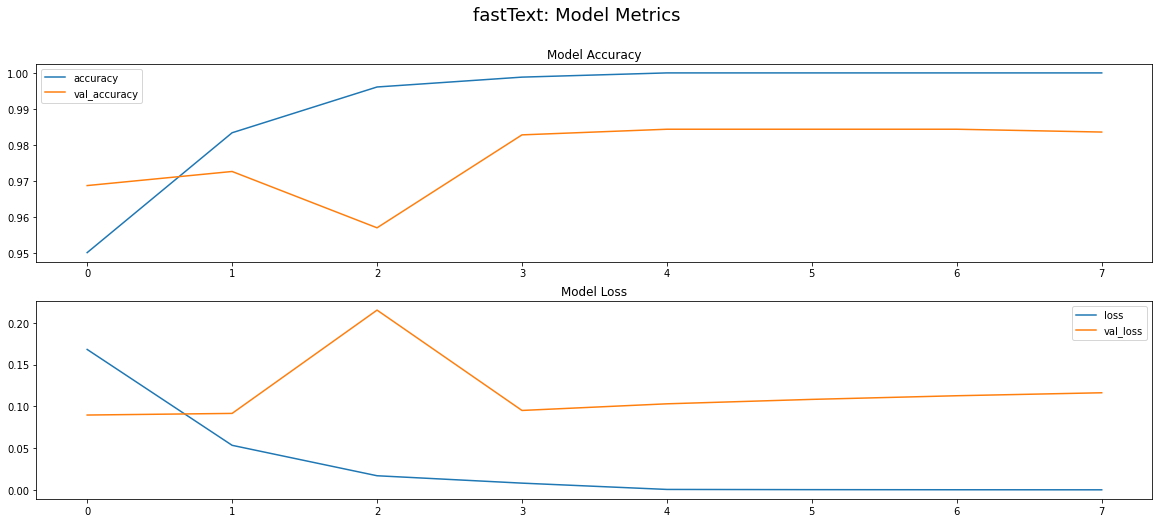

In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model_fastText.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

embedding_matrix = prepare_embedding_matrix(
    *prepare_embedding_index('fastText'), VOC_SIZE=VOC_SIZE, tokenizer=x_tokenizer)

model = Sequential()
model.add(Embedding(VOC_SIZE, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_TEXT_LEN, trainable=True))

model.add(Bidirectional(LSTM(32,dropout=0.3,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128,dropout=0.3,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,dropout=0.3)))

model.add(Dense(1, activation='sigmoid'))  

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

model.summary()
#plot_model(model, show_shapes=True)

history = model.fit(x_train,y_train, epochs=MAX_EPOCHS, validation_data=(x_val, y_val), callbacks=[es, ckpt, rlp],batch_size=BATCH_SIZE)

plot_model_learning(history, 'fastText')

### Model Evaluation

41/41 [==============================] - 28s 683ms/step - loss: 0.1163 - roc-auc: 0.9780 - accuracy: 0.9836 - precision: 0.9858 - recall: 0.9928 - f1_score: 0.9893
Accuracy: 98.36%

Classification report
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       304
           1       0.99      0.99      0.99       978

    accuracy                           0.98      1282
   macro avg       0.98      0.97      0.98      1282
weighted avg       0.98      0.98      0.98      1282

Confusion matrix : 290 14 7 971
{'NAME': ['bid_lstm', 'deep_bid_gru', 'FastText BILSTM Model'], 'METRICS': [[0.08010690659284592, 0.9877720475196838, 0.9875195026397705, 0.9888211488723755, 0.9948875308036804, 0.9918451309204102], [0.09318013489246368, 0.9808366298675537, 0.9828392863273621, 0.9838056564331055, 0.9938650131225586, 0.9888097643852234], [0.11630670726299286, 0.9780045747756958, 0.9836193323135376, 0.9857867956161499, 0.9928425550460815, 0.9893020987

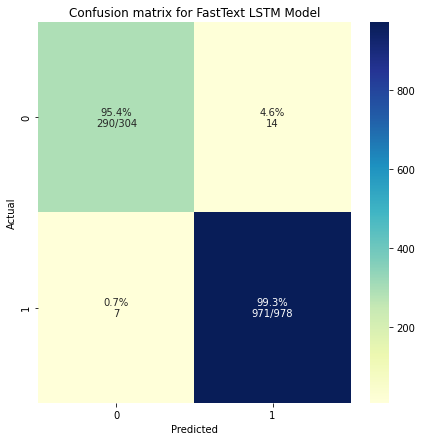

In [37]:
# Evaluate Model
scores = model.evaluate(x_val, y_val)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred=model.predict_classes(x_val)
print("\nClassification report\n",classification_report(y_val, y_pred))

#Confusion matrix
tn ,fb ,fn , tp= confusion_matrix(y_val, y_pred).ravel()
print("Confusion matrix :",tn ,fb ,fn , tp)

#plot Confusion matrix
plot_cm(y_val, y_pred, 'Confusion matrix for FastText LSTM Model', figsize=(7,7))

val_dict["NAME"].append("FastText BILSTM Model")
val_dict["METRICS"].append(scores)
val_dict["CONFUSION_MATRIX"].append([tn ,fb ,fn , tp])
print(val_dict)

### Evaluate Model on Test DataSet

51/51 [==============================] - 35s 677ms/step - loss: 0.1086 - roc-auc: 0.9804 - accuracy: 0.9844 - precision: 0.9859 - recall: 0.9933 - f1_score: 0.9896
Accuracy: 98.44%

Classification report
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       405
           1       0.99      0.99      0.99      1198

    accuracy                           0.98      1603
   macro avg       0.98      0.98      0.98      1603
weighted avg       0.98      0.98      0.98      1603

Confusion matrix: 388 17 8 1190


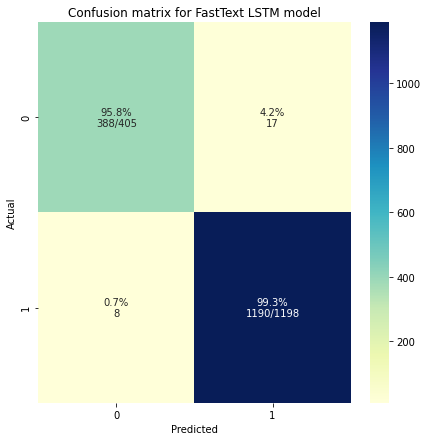

In [38]:
# Evaluate Model
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_test)
print("\nClassification report\n",classification_report(y_test, y_pred))

#Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion matrix:", tn, fp, fn, tp)

#plot Confusion matrix
plot_cm(y_test, y_pred, 'Confusion matrix for FastText LSTM model', figsize=(7,7))

test_dict["NAME"].append("FastText BILSTM model")
test_dict["METRICS"].append(scores)
test_dict["CONFUSION_MATRIX"].append([tn, fp, fn, tp])

### Sample

In [39]:
text_example = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/Data/text_example.csv")
text_example.shape
count=0

for text in text_example.text:
  text_seq =  x_tokenizer.texts_to_sequences([text])
  text_pad   =   pad_sequences(text_seq,maxlen=MAX_TEXT_LEN, padding='post')
  y_label  =   model.predict_classes(text_pad)
  # y_pred= np.where(y_label > .5, 1, 0)
  if y_label==1 :
    count=count+1
    
print("Real : "+str(count))

Real : 17


# Result Summery

## Validation Result

In [40]:
print('{0:15}{1:105}{2:10}'.format('algorithm', 'metric(loss,roc,accuercy,recall,persion,f1_score)','confusion_matrix'))
print('---------------------------------------------------------------------')
for i in range(3):
  print('{0:15}{1:105}{2:10}'.format(val_dict["NAME"][i], str(val_dict["METRICS"][i]),str(val_dict["CONFUSION_MATRIX"][i])))

algorithm      metric(loss,roc,accuercy,recall,persion,f1_score)                                                        confusion_matrix
---------------------------------------------------------------------
bid_lstm       [0.08010690659284592, 0.9877720475196838, 0.9875195026397705, 0.9888211488723755, 0.9948875308036804, 0.9918451309204102][293, 11, 5, 973]
deep_bid_gru   [0.09318013489246368, 0.9808366298675537, 0.9828392863273621, 0.9838056564331055, 0.9938650131225586, 0.9888097643852234][288, 16, 6, 972]
FastText BILSTM Model[0.11630670726299286, 0.9780045747756958, 0.9836193323135376, 0.9857867956161499, 0.9928425550460815, 0.9893020987510681][290, 14, 7, 971]


## Test Result

In [41]:
print('{0:15}{1:105}{2:10}'.format('algorithm', 'metric(loss,roc,accuercy,recall,persion,f1_score)','confusion_matrix'))
print('---------------------------------------------------------------------')
for i in range(3):
  print('{0:15}{1:105}{2:10}'.format(test_dict["NAME"][i], str(test_dict["METRICS"][i]),str(test_dict["CONFUSION_MATRIX"][i])))



algorithm      metric(loss,roc,accuercy,recall,persion,f1_score)                                                        confusion_matrix
---------------------------------------------------------------------
bid_lstm       [0.10076779872179031, 0.9841897487640381, 0.9806612730026245, 0.980246901512146, 0.9941569566726685, 0.9871529340744019][381, 24, 7, 1191]
deep_bid_gru   [0.0970279723405838, 0.9826873540878296, 0.9800374507904053, 0.9842192530632019, 0.9891485571861267, 0.9866777658462524][386, 19, 13, 1185]
FastText BILSTM model[0.10859676450490952, 0.9804468154907227, 0.9844042658805847, 0.98591548204422, 0.9933221936225891, 0.9896050095558167][388, 17, 8, 1190]
